# 1. 데이터 확인 
- DESCR : 데이터 설명
- data, target(레이블)

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

/opt/homebrew/lib/python3.10/site-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X,y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

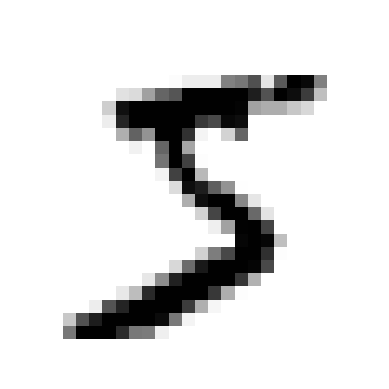

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit=X[0]
some_digit_image=some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0] #label이 문자열로 5임

'5'

In [6]:
import numpy as np
y=y.astype(np.uint8) #숫자로 변환

# 2. Devide test set

In [7]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:], y[:60000],y[60000:]

# 3. Binary Classification
### SGDClassifier
- 매우 큰 데이터 셋을 효율적으로 처리한다(온라인 학습에 적정)
- 확률적 경사하강법
    
### Batch vs, Stochastic gradient descent
- 경사하강법
    - 비용함수를 제곱오차합 sum((y-y')^2)으로 정의
        - 연속함수= 미분가능함
    - 그래디언트(각 가중치에 대한 편미분값)*학습률 누적하여 가중치 업데이트 
- 배치 경사하강법
    - epoch당 전체 데이터에 대해 계산한한 그래디언트
    - 모든 가중치 한 번에 업데이트
- 확률적 경사하강법
    - epoch당 모든 데이터 순회하며 1개 샘플(1개 가중치)씩만 업데이트
    - 훈련샘플을 무작위하게 주입하는 것이 좋음
        - 시계열 데이터는 섞으면 안 됨
- 미니배치 경사하강법
    - 일부씩 확률적 경사하강법 적용

In [8]:
from sklearn.linear_model import SGDClassifier

y_train_5= (y_train ==5)
y_tetst_5= (y_test==5)

sgd_model= SGDClassifier(random_state=42)
sgd_model.fit(X_train, y_train_5)

sgd_model.predict([some_digit])

array([ True])

# 4. Classification metrics
- StratifiedKfold, Cross validation
    - 정확도를 사용하는데 불균형한 데이터 셋을 다룰 때 별로 신뢰성 없음
    - ex) 전체데이터의 10%만 5이기 때문에 모두 5아님으로 판단해도 정확도 90% 나옴
- Confusion matrix
    - 정밀도: 전체 양성 판정에 대한 양성 판정 성공률
    - 재현율: 전체 실제 양성에 대한 양성 판정 성공률
    - f1 score: 정밀도와 재현율의 조화 평균 - 데이터 불균형한 경우 크게 영향 안 받음
    - 상황에 따라 둘 중 하나가 중요한데, 둘이 트레이드 오프관계
- ROC Curve, AUC
    - 정밀도가 높아도 재현율이 너무 낮으면 성능지표로 삼을 수 없음
    - TPR/FPR
    - AUC가 1에 가까울 수록 좋은 성능

In [9]:
# StratifiedKfold, Cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf= clone(sgd_model)
    X_train_folds= X_train[train_index]
    y_train_folds= y_train_5[train_index]
    X_test_folds= X_train[test_index]
    y_test_folds= y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred= clone_clf.predict(X_test_folds)
    n_correct= sum(y_pred==y_test_folds)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_model, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# 모두 5 아님으로 판단하는 분류기 성능도 정확도 0.9로 나옴
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros(len(X))
    
never5= Never5Classifier()
cross_val_score(never5, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### 분류기에 적합한 성능지표 - Precision, TPR

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_train_pred= cross_val_predict(sgd_model, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)
f1_score(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### 분류기에 적합한 성능지표 - ROC, AUC

In [14]:
from sklearn.metrics import roc_auc_score

# 반환값으로 예측말고 결정함수 값(점수)를 반환하도록 함
y_scores= cross_val_predict(sgd_model, X_train, y_train_5, cv=3, method='decision_function')
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [17]:
# SGD와 랜덤 포레스트 성능비교
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve

forest_model = RandomForestClassifier(random_state=42)
y_probas_forest= y_scores= cross_val_predict(forest_model, X_train, y_train_5, cv=3, method='predict_proba')

#점수대신 확률 사용
y_scores_forest=y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/opt/homebrew/opt/ipython/libexec/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/opt/ipython/libexec/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/opt/ipython/libexec/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/opt/ipython/libexec/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/opt/ipython/libexec/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE 

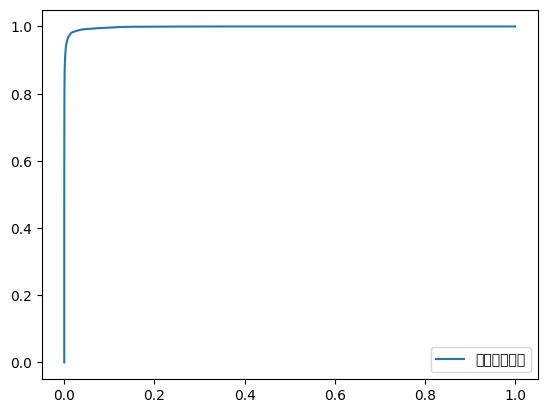

In [19]:
plt.plot(fpr_forest, tpr_forest, label='랜덤포레스트')
plt.legend(loc='lower right')
plt.show()

# 5. 기타
### 에러분석
- 오차행렬(cross_val_predict, confusion_matrix)
- 데이터가 적거나 특정 클래스의 분류성공률이 낮은 경우
    - 데이터 증식(훈련세트 확장)기법 적용가능

### 다중 분류
- 이진분류만 지원하는 경우 OvR(클래스별 TF 판별기), OvO(클래스i와 클래스j 판별기) 가능

### 다중 레이블 분류
- 
